In [11]:
import importlib
import uproot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nue as nue
importlib.reload(nue)

<module 'nue' from '/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/nue.py'>

# notes

we're using cheat pandora! 

In [12]:
nue_file = "/sbnd/data/users/lynnt/v09_75_03_02/data_caf_cheat.df"
nue_hdr_df_0 = pd.read_hdf(nue_file,key="hdr")
nue_nuu_df_0 = pd.read_hdf(nue_file,key="mcnu")
nue_nuprim_df_0 = pd.read_hdf(nue_file,key="mcnuprim")
nue_slctrk_df_0 = pd.read_hdf(nue_file,key="slctrk")
nue_slcshw_df_0 = pd.read_hdf(nue_file,key="slcshw")

nu_idx_set = ["ntuple","entry","nu_index"]
slc_idx_set = ["ntuple","entry","rec.slc__index"]

nue_hdr_df = nue.flatten_df(nue_hdr_df_0)[["ntuple","entry","rec_hdr_run","rec_hdr_subrun","rec_hdr_evt","rec_hdr_pot"]].rename(columns={"rec_hdr_subrun":"subrun","rec_hdr_run":"run","rec_hdr_evt":"event"})
nue_sub_opt0_df = uproot.open("/sbnd/data/users/lynnt/v09_75_03_02/ana_opt0_cheat.root:opt0finder/flash_match_tree").arrays(['run','subrun','event'],library="pd").drop_duplicates()
nue_sub_df = nue_hdr_df.merge(nue_sub_opt0_df,on=["run","subrun",'event'],how="inner")

In [13]:
# make nue dataframes
nue_nuprim_df = nue_nuprim_df_0.copy()

whereFV = nue.maskTrueVtxFv(nue_nuprim_df)
whereSig = ((nue_nuprim_df.iscc==1) & (abs(nue_nuprim_df.pdg)==12) & (abs(nue_nuprim_df.prim.pdg)==11))# & (nue_nuprim_df.prim.startE > 0.2) )
nue_nuprim_df = nue.defineBackground(nue_nuprim_df)
nue_nuprim_df["signal"] = np.where(whereFV & whereSig,0,nue_nuprim_df["signal"])

nue_nu_df = nue_nuprim_df.loc[:,:,:,0]
nue_nu_df = nue.flatten_df(nue_nu_df)
nue_nu_df["nu_index"] = nue_nu_df["rec.mc.nu__index"]

# get the dataframe that contains the counts of each PDG per event 
nue_pdg_counts = nue.getPDGCounts(nue_nuprim_df)

# merge the pdg counts into the full nue_nu_df 
nue_nu_df = nue_nu_df.merge(nue_pdg_counts,how="left",on=["ntuple","entry","rec.mc.nu__index"])

# get slcpfp dataframe 
slcpfp_nue_df = nue.getPFP(nue_slcshw_df_0,nue_slctrk_df_0,cheat=True)

# merge slcpfp with neutrino events 
slcpfp_nue_nu_df = slcpfp_nue_df.merge(nue_nu_df,on=nu_idx_set,how="left")
slcpfp_nue_nu_df["signal"] = np.where(slcpfp_nue_df.slc_tmatch_idx==-999,5,slcpfp_nue_nu_df['signal'])

(array([5.5467e+04, 4.5355e+04, 2.7146e+04, 5.4330e+03, 1.1080e+03,
        1.6100e+02, 7.7000e+01, 3.5000e+01, 2.4000e+01, 1.8000e+01]),
 array([ 0. ,  7.5, 15. , 22.5, 30. , 37.5, 45. , 52.5, 60. , 67.5, 75. ]),
 <BarContainer object of 10 artists>)

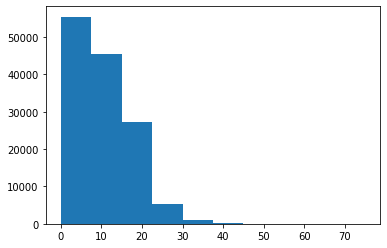

In [15]:
plt.hist(slcpfp_nue_nu_df["rec.slc__index"])

for this sample, intrnue + cosmics, we can break-down the components of our events into: 
- 1eNp0pi FV (signal)
- numuCC FV
- nue NC, FV 
- other nueCC, FV 
- dirt (outside FV)

In [16]:
nue_opt0_df = uproot.open("/sbnd/data/users/lynnt/v09_75_03_02/ana_opt0_cheat.root:opt0finder/flash_match_tree").arrays(['run','subrun','event','tpc','pfpid','score','hypo_pe','flash_pe'],library="pd")
nue_opt0_df["frac_pe"] = (nue_opt0_df.hypo_pe - nue_opt0_df.flash_pe)/nue_opt0_df.flash_pe
nue_opt0_df = nue_opt0_df[nue_opt0_df.pfpid != -1]

# for multiple matches per slice, take the match with the best score
nue_opt0_df = nue_opt0_df[(nue_opt0_df.score == nue_opt0_df.groupby(["run","subrun","event","pfpid"])["score"].transform(max))]
nue_hdr_opt0_df = nue_sub_df[["ntuple","entry","run","subrun","event"]].drop_duplicates().merge(nue_opt0_df,how="left",on=["run","subrun","event"])
slcpfp_nue_nu_df = slcpfp_nue_nu_df.merge(nue_hdr_opt0_df.rename(columns={"pfpid":"slc_self"}),on=["ntuple","entry","slc_self"],how="left")

In [19]:
nue_opt0_df

,run,subrun,event,tpc,pfpid,score,hypo_pe,flash_pe,frac_pe


In [13]:
# print number of slc/evt for nue selection
print("number of signal events:", len(nue.get_signal_evt(nue_nu_df)))
print("number of signal slices (evt) after reconstruction: ", 
      len(nue.get_signal_slc(slcpfp_nue_nu_df)),
      "(",len(nue.get_signal_evt(slcpfp_nue_nu_df)),")")

# pre-selection
## reco vertex in FV 
## not a clear cosmic 
## at least one pfp in a slice with track score < 0.6
pre_slcpfp_nue_nu_df = nue.cutPreselection(slcpfp_nue_nu_df)
print("number of signal slices (evt) after pre-selection: ", 
      len(nue.get_signal_slc(pre_slcpfp_nue_nu_df)),
      "(",len(nue.get_signal_evt(pre_slcpfp_nue_nu_df)),")")
# containment
con_slcpfp_nue_nu_df = nue.cutContainment(pre_slcpfp_nue_nu_df)
print("number of signal slices (evt) after containment: ", 
      len(nue.get_signal_slc(con_slcpfp_nue_nu_df)),
      "(",len(nue.get_signal_evt(con_slcpfp_nue_nu_df)),")")
# loose cosmic rejection 
lcr_slcpfp_nue_nu_df = nue.cutCRUMBS(con_slcpfp_nue_nu_df)
print("number of signal slices (evt) after loose cosmic rejection: ",
        len(nue.get_signal_slc(lcr_slcpfp_nue_nu_df)),
        "(",len(nue.get_signal_evt(lcr_slcpfp_nue_nu_df)),")")
# muon rejection
mask_muon_dazzle = ~(lcr_slcpfp_nue_nu_df.groupby(slc_idx_set)["pfp_trk_dazzle_muonScore"].transform(lambda x: (x > 0.2).any()))
mrj_slcpfp_nue_nu_df = lcr_slcpfp_nue_nu_df[mask_muon_dazzle]
print("number of signal slices (evt) after muon rejection: ",
        len(nue.get_signal_slc(mrj_slcpfp_nue_nu_df)),
        "(", len(nue.get_signal_evt(mrj_slcpfp_nue_nu_df)),")")

mask_electron_razzle = (mrj_slcpfp_nue_nu_df.groupby(slc_idx_set)["pfp_shw_razzle_electronScore"].transform(lambda x: (x > 0.5).any()))
esl_slcpfp_nue_nu_df = mrj_slcpfp_nue_nu_df[mask_electron_razzle]
print("number of signal slices (evt) after electron selection: ",
      len(nue.get_signal_slc(esl_slcpfp_nue_nu_df)),
      "(",len(nue.get_signal_evt(esl_slcpfp_nue_nu_df)),")")

mask_shower_energy = (esl_slcpfp_nue_nu_df.groupby(slc_idx_set)["shw_energy"].transform(lambda x: (x > 0.2).any()))
shw_slcpfp_nue_nu_df = esl_slcpfp_nue_nu_df[mask_shower_energy]
print("number of signal slices after shower energy cut: ",len(nue.get_signal_slc(shw_slcpfp_nue_nu_df)))

number of signal events: 2564
number of signal slices (evt) after reconstruction:  0 ( 0 )


AttributeError: 'DataFrame' object has no attribute 'signal'

In [50]:
print("number of signal slices before trk/shw containment cut: ",len(get_slices(pre_slcpfp_nu_df,0)))
print("number of cosmic slices before trk/shw containment cut: ",len(get_slices(pre_slcpfp_nu_df,5)))

# track containment cut 
trk_subset = pre_slcpfp_nu_df
whereTrkCont = (((pre_slcpfp_nu_df.pfp_trackScore > 0.5) & 
                                 (abs(pre_slcpfp_nu_df.pfp_trk_end_x) < 195) &
                                 (pre_slcpfp_nu_df.pfp_trk_end_y > -195)  & (pre_slcpfp_nu_df.pfp_trk_end_y < 195) &
                                 (pre_slcpfp_nu_df.pfp_trk_end_z > 5)    & (pre_slcpfp_nu_df.pfp_trk_end_z < 495)) | 
                                (pre_slcpfp_nu_df.pfp_trackScore < 0.5))
# shower containment cut

whereShwCont = (((pre_slcpfp_nu_df.pfp_trackScore < 0.5) & 
                (abs(pre_slcpfp_nu_df.pfp_shw_end_x) < 195) &
                (pre_slcpfp_nu_df.pfp_shw_end_y > -195)  & (pre_slcpfp_nu_df.pfp_shw_end_y < 195) &
                (pre_slcpfp_nu_df.pfp_shw_end_z > 5)    & (pre_slcpfp_nu_df.pfp_shw_end_z < 495)) | 
                (pre_slcpfp_nu_df.pfp_trackScore > 0.5))

print("number of signal slices after trk/shw containment cut: ",len(get_slices(pre_slcpfp_nu_df[whereTrkCont & whereShwCont],0)))
print("number of cosmic slices after trk/shw containment cut: ",len(get_slices(pre_slcpfp_nu_df[whereTrkCont & whereShwCont],5)))


number of signal slices before trk/shw containment cut:  4130
number of cosmic slices before trk/shw containment cut:  2957
number of signal slices after trk/shw containment cut:  4074
number of cosmic slices after trk/shw containment cut:  2856


In [11]:
print("number of signal slices after nominal crumbs cut:", len(get_slices(slc_opt0_df[slc_opt0_df.slc_crumbs_result_score>-0.15],0)))
print("number of dirt   slices after nominal crumbs cut:", len(get_slices(slc_opt0_df[slc_opt0_df.slc_crumbs_result_score>-0.15],4)))
print("number of cosmic slices after nominal crumbs cut: ", len(get_slices(slc_opt0_df[slc_opt0_df.slc_crumbs_result_score>-0.15],5)))
print("number of signal slices after low/high combination: ", len(get_slices(slc_opt0_df[(slc_opt0_df.slc_crumbs_result_score>-0.1) | 
                                                                                         ((slc_opt0_df.slc_crumbs_result_score< -0.1) & (slc_opt0_df.slc_crumbs_result_score> -0.25) & (abs(slc_opt0_df.frac_pe) < 0.25))],0)))
print("number of dirt   slices after low/high combination: ", len(get_slices(slc_opt0_df[(slc_opt0_df.slc_crumbs_result_score>-0.1) | 
                                                                                         ((slc_opt0_df.slc_crumbs_result_score<-0.1) & (slc_opt0_df.slc_crumbs_result_score> -0.25) & (abs(slc_opt0_df.frac_pe) < 0.25))],4)))
print("number of cosmic slices after low/high combination: ", len(get_slices(slc_opt0_df[(slc_opt0_df.slc_crumbs_result_score>-0.1) | 
                                                                                         ((slc_opt0_df.slc_crumbs_result_score<-0.1) & (slc_opt0_df.slc_crumbs_result_score> -0.25) & (abs(slc_opt0_df.frac_pe) < 0.25))],5)))

number of signal slices after nominal crumbs cut: 3963
number of dirt   slices after nominal crumbs cut: 152
number of cosmic slices after nominal crumbs cut:  185
number of signal slices after low/high combination:  4002
number of dirt   slices after low/high combination:  147
number of cosmic slices after low/high combination:  151


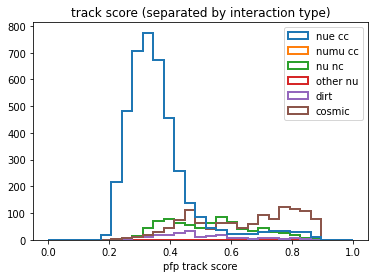

In [12]:
# loose cosmic rejection stage
this_df = pre_slcpfp_nu_df[pre_slcpfp_nu_df.slc_crumbs_result_score>-0.3]
plot_var(df=this_df,
         var="pfp_trackScore",
         bins=np.linspace(0,1,30),
         label="pfp track score",
         title="track score (separated by interaction type)",
         cut_val=[],)

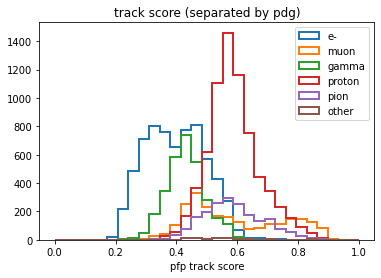

In [13]:
# loose cosmic rejection stage
this_df = pre_slcpfp_nu_df[pre_slcpfp_nu_df.slc_crumbs_result_score>-0.3]
plot_var_pdg(df=this_df,
         var="pfp_trackScore",
         bins=np.linspace(0,1,30),
         label="pfp track score",
         title="track score (separated by pdg)",
         cut_val=[],)

In [32]:
pre_slcpfp_nu_df.columns

Index(['ntuple', 'entry', 'rec.slc__index', 'rec.slc.reco.pfp__index',
       'slc_is_clear_cosmic', 'slc_vertex_x', 'slc_vertex_y', 'slc_vertex_z',
       'slc_self', 'slc_tmatch_eff', 'slc_tmatch_pur', 'slc_tmatch_idx',
       'slc_producer', 'slc_nu_pdg', 'slc_nu_score', 'slc_crumbs_result_score',
       'slc_fmatch_score', 'slc_fmatch_time', 'pfp_shw_producer',
       'pfp_shw_start_x', 'pfp_shw_start_y', 'pfp_shw_start_z',
       'pfp_shw_end_x', 'pfp_shw_end_y', 'pfp_shw_end_z',
       'pfp_shw_conversion_gap', 'pfp_shw_bestplane', 'pfp_shw_bestplane_dEdx',
       'pfp_shw_bestplane_energy', 'pfp_shw_plane_I0_energy',
       'pfp_shw_plane_I1_energy', 'pfp_shw_plane_I2_energy',
       'pfp_shw_plane_I0_nHits', 'pfp_shw_plane_I1_nHits',
       'pfp_shw_plane_I2_nHits', 'pfp_shw_razzle_electronScore',
       'pfp_shw_truth_p_pdg', 'pfp_shw_truth_p_startE', 'pfp_shw_truth_p_endE',
       'pfp_slcID', 'pfp_trackScore', 'pfp_parent', 'pfp_id', 'tindex_x',
       'nu_index', 'pfp_trk_p

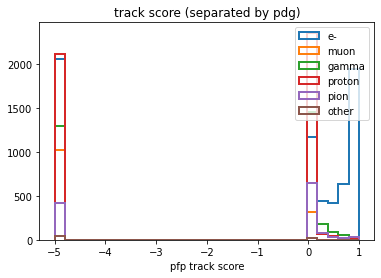

In [38]:
# loose cosmic rejection stage
this_df = pre_slcpfp_nu_df[(pre_slcpfp_nu_df.slc_crumbs_result_score>-0.3) & (pre_slcpfp_nu_df.pfp_trackScore < 0.6)]
plot_var_pdg(df=this_df,
         var="pfp_shw_razzle_electronScore",
         bins=np.linspace(-5,1,30),
         label="pfp track score",
         title="track score (separated by pdg)",
         cut_val=[],)

In [14]:
slc_opt0_df["frac_pe"] = np.where(slc_opt0_df.score.isna()==True,-1.1,slc_opt0_df.frac_pe)
slc_opt0_df["score"] = np.where(slc_opt0_df.score.isna()==True,1,slc_opt0_df.score)

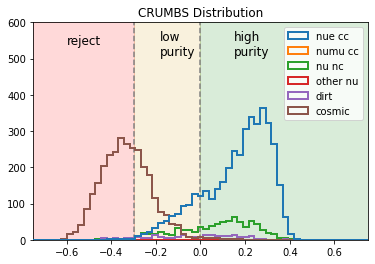

In [15]:
# bins=np.logspace(-5,0,30)

bins=np.linspace(-.75,.75,60)
plt.axvspan(bins[0],-0.3,color="red",alpha=0.15)
plt.axvspan(-0.3,0.0,color="goldenrod",alpha=0.15)
plt.axvspan(0.0,bins[-1],color="green",alpha=0.15)
ymin = 0
ymax = 600
plt.ylim(ymin,ymax)# plt.xscale('log')
plt.vlines(ymin=ymin,ymax=ymax,x=0.0,color="gray",linestyle="--")
plt.vlines(ymin=ymin,ymax=ymax,x=-0.3,color="gray",linestyle="--")
plt.xlim(bins[0],bins[-1])

plt.annotate(xy=(0.1,0.9),xycoords="axes fraction", text="reject",fontsize=12)
plt.annotate(xy=(0.38,0.85),xycoords="axes fraction", text="low\npurity",fontsize=12)
plt.annotate(xy=(0.6,0.85),xycoords="axes fraction", text="high\npurity",fontsize=12)

plot_var(df=slc_opt0_df,
         var="slc_crumbs_result_score",
         bins=bins,
         label="",
         title="CRUMBS Distribution",
         cut_val=[],)
plt.show()

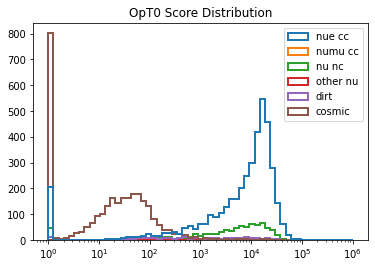

In [16]:
bins=np.logspace(0,6,60)
# bins=np.linspace(-1,1,30)
# plt.axvspan(1,10**1.5,color="red",alpha=0.15)
# plt.axvspan(10**1.5,1e3,color="goldenrod",alpha=0.15)
# plt.axvspan(1e3,1e5,color="green",alpha=0.15)
plt.xscale('log')
plot_var(df=slc_opt0_df,
         var="score",
         bins=bins,
         label="",
         title="OpT0 Score Distribution",
         cut_val=[],)
# ymin, ymax = plt.ylim()
# plt.vlines(ymin=ymin,ymax=ymax,x=1e3,color="gray",linestyle="--")
# plt.vlines(ymin=ymin,ymax=ymax,x=10**1.5,color="gray",linestyle="--")

# plt.annotate(xy=(0.1,0.9),xycoords="axes fraction", text="reject",fontsize=12)
# plt.annotate(xy=(0.4,0.9),xycoords="axes fraction", text="low purity",fontsize=12)
# plt.annotate(xy=(0.65,0.85),xycoords="axes fraction", text="high \npurity",fontsize=12)

# plt.xlim(bins[0],bins[-1])
# plt.ylim(ymin,ymax)

plt.show()

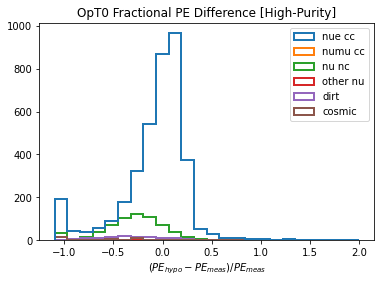

In [17]:
high_pur_df = slc_opt0_df[(slc_opt0_df.slc_crumbs_result_score > -0.1)]
bins=np.linspace(-1.1,2,25)
plot_var(df=high_pur_df,
         var="frac_pe",
         bins=bins,
         label=r"$(PE_{hypo} - PE_{meas}) / PE_{meas}$",
         title="OpT0 Fractional PE Difference [High-Purity]",
         cut_val=[],)

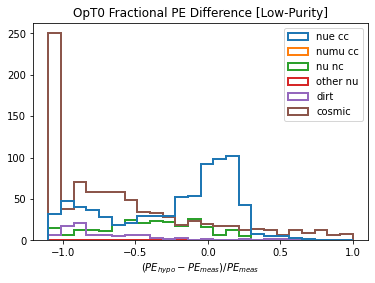

In [18]:
low_pur_df = slc_opt0_df[(((slc_opt0_df.slc_crumbs_result_score < 0)))
                         & ((slc_opt0_df.slc_crumbs_result_score > -0.3))
                         ]
bins=np.linspace(-1.1,1,25)
plot_var(df=low_pur_df,
         var="frac_pe",
         bins=bins,
         label=r"$(PE_{hypo} - PE_{meas}) / PE_{meas}$",
         title="OpT0 Fractional PE Difference [Low-Purity]",
         cut_val=[],)
plt.show()

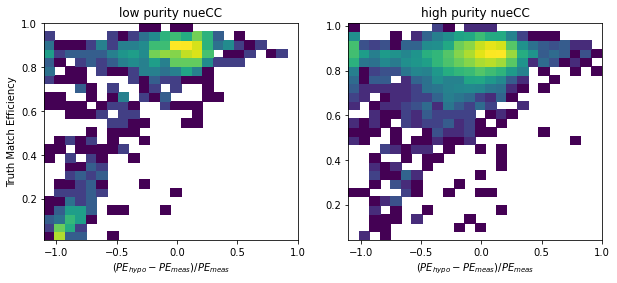

In [19]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].hist2d(low_pur_df[low_pur_df.signal==0].frac_pe, low_pur_df[low_pur_df.signal==0].slc_tmatch_eff    , bins=[np.linspace(-1.1,1,25),25],norm=mpl.colors.LogNorm())
axes[1].hist2d(high_pur_df[high_pur_df.signal==0].frac_pe, high_pur_df[high_pur_df.signal==0].slc_tmatch_eff, bins=[np.linspace(-1.1,1,25),25],norm=mpl.colors.LogNorm())
axes[0].set_title("low purity nueCC",fontsize=12)
axes[1].set_title("high purity nueCC",fontsize=12)
axes[0].set_ylabel("Truth Match Efficiency")
axes[0].set_xlabel(r"$(PE_{hypo} - PE_{meas}) / PE_{meas}$")
axes[1].set_xlabel(r"$(PE_{hypo} - PE_{meas}) / PE_{meas}$")

plt.show()

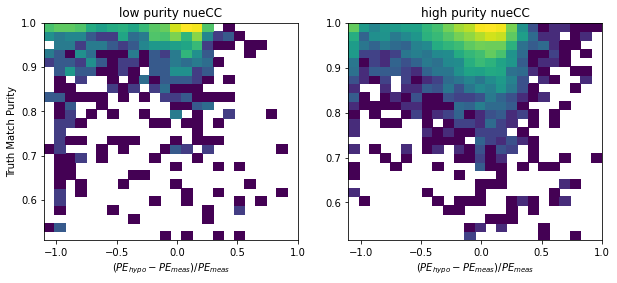

In [20]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].hist2d(low_pur_df[low_pur_df.signal==0].frac_pe, low_pur_df[low_pur_df.signal==0].slc_tmatch_pur    , bins=[np.linspace(-1.1,1,25),25],norm=mpl.colors.LogNorm())
axes[1].hist2d(high_pur_df[high_pur_df.signal==0].frac_pe, high_pur_df[high_pur_df.signal==0].slc_tmatch_pur, bins=[np.linspace(-1.1,1,25),25],norm=mpl.colors.LogNorm())
axes[0].set_title("low purity nueCC",fontsize=12)
axes[1].set_title("high purity nueCC",fontsize=12)
axes[0].set_ylabel("Truth Match Purity")
axes[0].set_xlabel(r"$(PE_{hypo} - PE_{meas}) / PE_{meas}$")
axes[1].set_xlabel(r"$(PE_{hypo} - PE_{meas}) / PE_{meas}$")
plt.show()

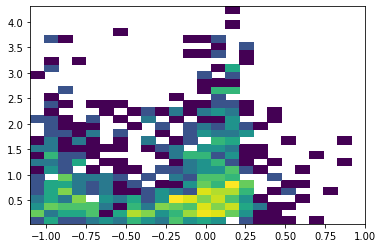

In [21]:
plt.hist2d(low_pur_df[low_pur_df.signal == 0].frac_pe,
           low_pur_df[low_pur_df.signal == 0].prim_startE,
           bins=[bins,30],
           norm=mpl.colors.LogNorm())
plt.show()

In [22]:
npts = 50
crumbs_eff = np.zeros(npts) 
crumbs_pur = np.zeros(npts) 
opt0_eff   = np.zeros(npts)
opt0_pur   = np.zeros(npts)

this_nu = slc_opt0_df[(slc_opt0_df.signal < 4)]
this_co = slc_opt0_df[(slc_opt0_df.nu_index >= 4)]

for i in range(npts):
    crumbs_cut = np.linspace(-0.5,0.3,npts)[i]
    opt0_cut = np.logspace(1,4,npts)[i]
    
    crumbs_eff[i] = len(this_nu[this_nu.slc_crumbs_result_score > crumbs_cut].index)/len(this_nu.index)
    opt0_eff[i] =   len(this_nu[this_nu.score > opt0_cut].index)/len(this_nu.index)
    
    crumbs_pur[i] = len(this_nu[this_nu.slc_crumbs_result_score > crumbs_cut].index)/len(slc_opt0_df[slc_opt0_df.slc_crumbs_result_score > crumbs_cut].index)
    opt0_pur[i] =   len(this_nu[this_nu.score > opt0_cut].index)/len(slc_opt0_df[slc_opt0_df.score > opt0_cut].index)

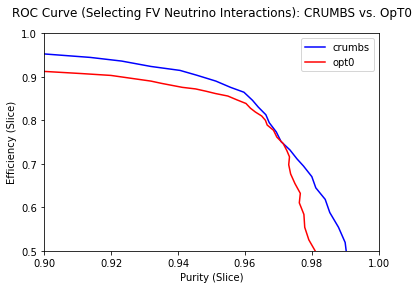

In [23]:
# slices in these plots have undergone reco vertex FV cut ONLY 
plt.plot(crumbs_pur,crumbs_eff,label="crumbs",color="blue")
plt.plot(opt0_pur,opt0_eff    ,label="opt0"  ,color="red")
plt.xlim(0.9,1.0)
plt.ylim(0.5,1.0)
plt.ylabel("Efficiency (Slice)")
plt.xlabel("Purity (Slice)")
plt.title("ROC Curve (Selecting FV Neutrino Interactions): CRUMBS vs. OpT0", y=1.05)
plt.legend()
plt.show()

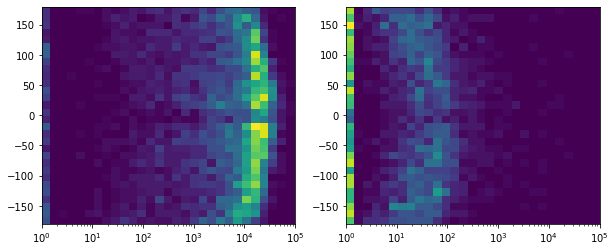

In [24]:
this_nu = slc_opt0_df[slc_opt0_df.nu_index!=-999]
this_co = slc_opt0_df[slc_opt0_df.nu_index==-999]

fig, axes = plt.subplots(1,2,sharex=True,figsize=(10,4))
bins=np.logspace(0,5,30)
axes[0].hist2d(this_nu.score,this_nu.slc_vertex_x,bins=[bins,30])
axes[1].hist2d(this_co.score,this_co.slc_vertex_x,bins=[bins,30])
axes[0].set_xscale('log')
# plt.legend()
plt.show()